# Mixed Model Investigation

We look at the results of a mixed-dataset RGB model largely based off of Albu's model performs. This model was trained on the Urban3D dataset, part of the Shanghai Training dataset (part of Spacenet AOI), and a CrowdAI dataset. The results are unastonishly bad, since these datasets share neither resolution, scale, color distributions, or actual picture dimensions. There is also a great imbalance in number of images. The Urban3D dataset has 178 2048x2048x3 images, Shanghai > 4,500 512x512 images, and the CrowdAI has 280,000 256x256 images. If you're curious about the color distributions, there's a notebook comparing them.

In [45]:
import numpy as np
import matplotlib.pyplot as plt

from pytorch_utils.eval import read_model
from mix_train import get_training_mappings
from pytorch_utils.eval import flip
from nbutils import (thresh, score_pred, load_img, make_input_tensor,
                     _mini_predict_on_file, get_saliency_big, plot_poly)
from config import Config

import torch, cv2, gdal, georaster
import sys, os, json, math

from pytorch_utils.loss import BCEDiceLoss
% matplotlib inline

In [2]:
from dataset.neural_dataset import MixedReadingImageProvider

In [3]:
cfg_f = '../resnet34_1x1080_mixed_RGB.json'
with open(cfg_f, 'r') as f:
    cfg = json.load(f)
    datasets = cfg.pop('datasets')
cfg = Config(**cfg)
model = read_model(cfg, '')

We used the full Urban3D and Shanghai datasets, but only 5% of the CrowdAI dataset, and this shows in the number of images below. 174 images for Urban3D, 4582 for Spacenet, and 14000 for CrowdAI.

In [5]:
sal_map = False
data_infos = [get_training_mappings(data, sal_map) for data in datasets]
mixed_ip = MixedReadingImageProvider(data_infos)

1.0 174
1.0 4582
0.05 14037


In [6]:
datasets = mixed_ip.ds_providers

An example from the spacenet dataset

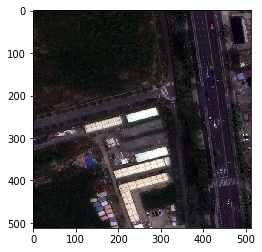

In [52]:
plt.imshow(datasets[1][0].read_image())

In [8]:
out = _mini_predict_on_file(model, datasets[1][0].read_image(), 
                        None, channels=3, flips=flip.FLIP_NONE).squeeze()

/home/ngundotra/.conda/envs/gdal/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/ngundotra/.conda/envs/gdal/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


This is the corresponding thresholded mask that would have been submitted if this was the Urban3D competition. Note that thresholding has hyperparameters that need to be tweaked to each dataset, and we show this further down, but the results are still useless.

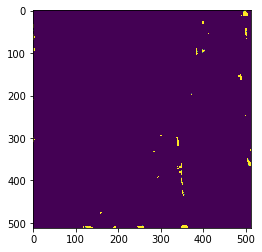

In [9]:
plt.imshow(out)

In [16]:
datasets[0].image_type, datasets[1].image_type, datasets[2].image_type

(dataset.tiff_image.TiffImageType,
 dataset.spacenet_image.TiffSpacenetImageType,
 dataset.crowdai_image.CrowdAIImageType)

This is a function to just call the model on numpy image input, it's called shady predict because that's what the output of this model looks like.

In [37]:
def shady_predict(im):
    tens = torch.Tensor(np.transpose(im, (2, 0, 1))).unsqueeze(0).cuda()
    with torch.no_grad():
        out = model(tens)
    out = out.squeeze().cpu().numpy()
    return out

## Performance Comparison

In [60]:
def generate_plot(dataset, rows=5):
    """Plots the first five `rows` images & corresponding visuals for the given dataset"""
    plt.tight_layout()
    fig, axs = plt.subplots(figsize=(8, rows*2.05), nrows=rows, ncols=4)
    first = True
    for i in range(rows):
        left, lmid, rmid, right = axs[i]
        [a.axis('off') for a in axs[i]]
        im = dataset[i].read_image()
        left.imshow(im)
        naked_predict = shady_predict(im)
        lmid.imshow(naked_predict, cmap='gray')
        rmid.imshow(_mini_predict_on_file(model, im, None, channels=3).squeeze(), cmap='gray')
        mask = dataset[i].read_mask().squeeze()
        right.imshow(mask, cmap='gray')
    #     left.set_ylabel(str(i))
        if first:
            left.set_title("Picture")
            lmid.set_title("Output")
            rmid.set_title("Thresholded Output")
            right.set_title("Target Output")
            first = False
        else:
            loss = BCEDiceLoss().cuda()
            outt = torch.Tensor(naked_predict)
            maskt = torch.Tensor(mask)
            diceloss = loss(outt, maskt) / 3
            lmid.set_title("{:0.3f}".format(diceloss))
    plt.show(fig)

### Shanghai Dataset

It's pretty clear that the mixed model has learned to decrease loss by doing some simple edge detection, which is shown in the outputs of the model (2nd column). This is probably because CNNs are known to have issues with scale variance. Since the datasets differ in resolution, scale, color histograms, and resolution, only general functions of building-like structures are likely to emerge. 

/home/ngundotra/.conda/envs/gdal/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/ngundotra/.conda/envs/gdal/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/ngundotra/.conda/envs/gdal/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


<Figure size 432x288 with 0 Axes>

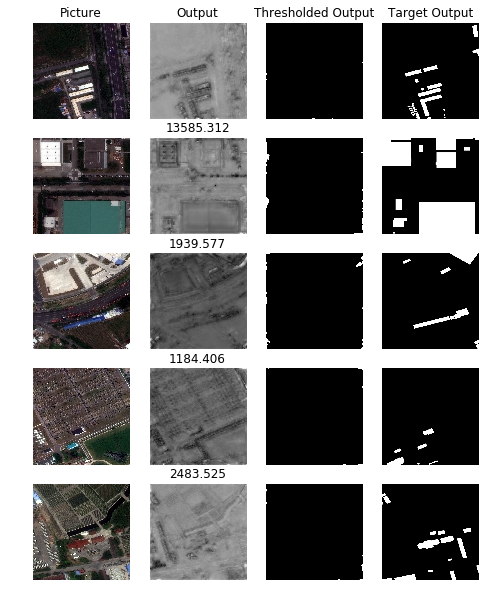

In [61]:
generate_plot(datasets[1], 5)

### CrowdAI Dataset

Same issue here, the model just reduced loss by predicting grayscale imagery 

/home/ngundotra/.conda/envs/gdal/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/ngundotra/.conda/envs/gdal/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/ngundotra/.conda/envs/gdal/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


<Figure size 432x288 with 0 Axes>

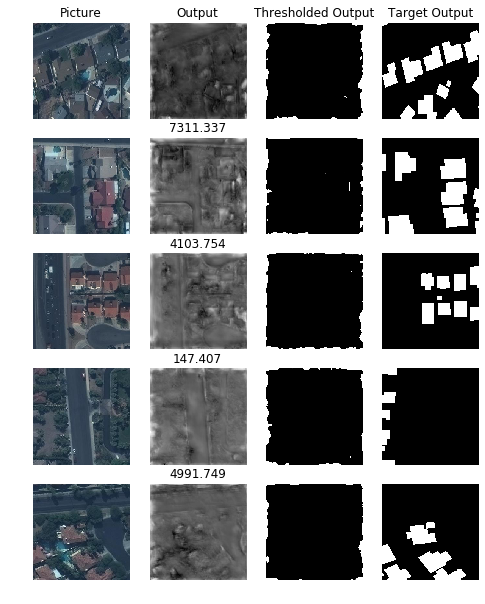

In [62]:
generate_plot(datasets[2], 5)

### Urban3D Dataset

Due to difficulties in predicting on an image

In [79]:
from nbutils import reconstruct, get_crops
def pred_u3d(model, big_img):
    parts = []
    for img in get_crops(big_img):
        parts.append(shady_predict(img))
    return reconstruct(*parts)

In [76]:
def generate_u3d(rows=5):
    """Plots the first five `rows` images & corresponding visuals for the given dataset"""
    plt.tight_layout()
    fig, axs = plt.subplots(figsize=(6, rows*2.05), nrows=rows, ncols=3)
    first = True
    for i in range(rows):
        left, lmid, right = axs[i]
        [a.axis('off') for a in axs[i]]
        im = datasets[0][i].read_image()[12:-12, 12:-12]
        left.imshow(im)
        naked_predict = pred_u3d(model, im)
        lmid.imshow(naked_predict, cmap='gray')
        mask = datasets[0][i].read_mask().squeeze()[12:-12, 12:-12]
        right.imshow(mask, cmap='gray')
    #     left.set_ylabel(str(i))
        if first:
            left.set_title("Picture")
            lmid.set_title("Output")
            right.set_title("Target Output")
            first = False
        else:
            loss = BCEDiceLoss().cuda()
            outt = torch.Tensor(naked_predict)
            maskt = torch.Tensor(mask)
            diceloss = loss(outt, maskt) / 3
            lmid.set_title("{:0.3f}".format(diceloss))
    plt.show(fig)

Due to reconstruction issues, 

/home/ngundotra/.conda/envs/gdal/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/ngundotra/.conda/envs/gdal/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/ngundotra/.conda/envs/gdal/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


<Figure size 432x288 with 0 Axes>

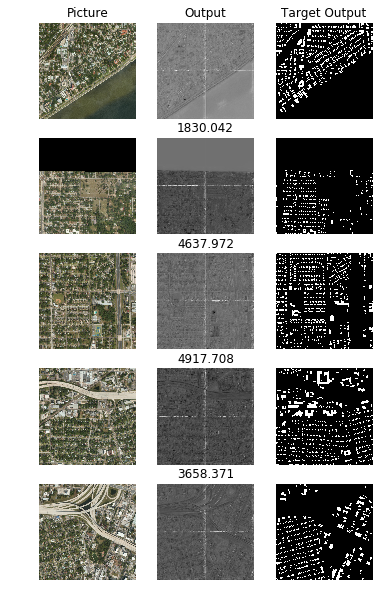

In [80]:
generate_u3d(rows=5)